# Libraries and Data Import
Also have a quick look at the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
repository_directory = "../"
construct_df_hd_model = True

In [47]:
df_source = pd.read_csv(repository_directory + "data/data_Q1_2021/2021-01-01.csv", parse_dates=["date"])
df_source.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000138625024,0,83.0,213166608.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,114.0,79306032.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000138625024,0,72.0,17162816.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,100.0,1102160.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000519643136,0,75.0,33233248.0,NaN,NaN,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_source.iloc[:,:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165512 entries, 0 to 165511
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                165512 non-null  datetime64[ns]
 1   serial_number       165512 non-null  object        
 2   model               165512 non-null  object        
 3   capacity_bytes      165512 non-null  int64         
 4   failure             165512 non-null  int64         
 5   smart_1_normalized  165394 non-null  float64       
 6   smart_1_raw         165394 non-null  float64       
 7   smart_2_normalized  62489 non-null   float64       
 8   smart_2_raw         62489 non-null   float64       
 9   smart_3_normalized  164256 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 12.6+ MB


In [4]:
df_source.nunique()

date                         1
serial_number           165512
model                       59
capacity_bytes              15
failure                      2
                         ...  
smart_252_raw                0
smart_254_normalized         2
smart_254_raw                1
smart_255_normalized         0
smart_255_raw                0
Length: 149, dtype: int64

In [5]:
df_source.groupby("failure").count()["serial_number"]

failure
0    165508
1         4
Name: serial_number, dtype: int64

# Some Useful Functions and Lists

In [6]:
# specify commonly used column names
column_name_all = df_source.columns
column_name_basic, column_name_smart = column_name_all[:5], column_name_all[5:]
column_name_smart_raw = pd.Index([c for c in column_name_smart if "raw" in c ])
column_name_smart_normalized = pd.Index([c for c in column_name_smart if "normalized" in c ])

# collections of important smart parameters from different sources
key_smart_backblaze = [5, 187, 188, 197, 198] # https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/
key_smart_wiki = [5, 10, 184, 187, 188, 196, 197, 198, 201] # https://en.wikipedia.org/wiki/S.M.A.R.T.
key_smart_ai_paper = [3, 5, 7, 187, 188, 190, 197, 198] # https://www.sciencedirect.com/science/article/pii/S2666827021000219
key_smart_power_on_time = [9]

# choose smart and set up the column name 
key_smart = [3, 5, 7, 9, 187, 188, 197, 198]
column_name = pd.Index(list(column_name_basic) + ["smart_" + str(i) + "_" + "raw" for i in key_smart])
print(column_name)

def smart2meaningful(col):
    """smart to meaningful names
    see wiki for more info: https://en.wikipedia.org/wiki/S.M.A.R.T.

    Args:
        col (panda.Index): name of columns returned from a dataframe

    Returns:
        panda.Index: a column with more meaningful names
    """
    dict_smart = {3   : "spin_up_time",
                  5   : "reallocated_sector_count", # or "bad-sector count" 
                  7   : "seek_error_rate", # or "reading-head seek-error rate", vendor-dependent
                  9   : "power_on_time", 
                  10  : "spin_retry_count",
                  184 : "end_to_end_error", # vendor-dependent
                  187 : "reported_uncorrectable_error",
                  188 : "command_timeout_count",
                  190 : "temperature_special", # vendor-dependent
                  194 : "temperature",
                  196 : "reallocation_event_count",
                  197 : "current_pending_sector_count", # or "unusable sector count"
                  198 : "uncorrectable_sector_count", 
                  201 : "software_read_error_count", 
                  231 : "expected_life_left"
    }
    col_modified = []
    for name in list(col):
        if "smart_" in name:
            number = int(name.split("smart_")[1].split("_")[0])
            if number in list(dict_smart.keys()):
                col_modified.append(name.replace("smart_" + str(number), dict_smart[number]))
            else:
                col_modified.append(name)
        else:
            col_modified.append(name)
    return pd.Index(col_modified)

# change the smart name into meaningful names for a dataframe
# this should be applied only after you perform all operations on columns
def smart2meaningful_for_dataframe(df):
    df.columns = smart2meaningful(df.columns)
    return df

# drop all smart columns except those specified by smart_to_keep
def keep_some_smart_column_for_dataframe(df, smart_to_keep=[], raw_or_normalized="raw"):
    cols = df.columns
    cols_nonsmart = [col for col in cols if not "smart_" in col]
    #cols_smart = [col for col in cols if "smart_" in col]
    #s = set(cols_smart)
    cols_smart = ["smart_" + str(i) + "_" + raw_or_normalized for i in smart_to_keep]
    return df[cols_nonsmart + cols_smart]

def change_feature_dtype_for_dataframe(df, feature_to_change=[]):
    col = df.columns
    for feature in feature_to_change:
        if not feature in col:
            print("### Error!")
            print(f"### The feature '{feature}' is not found in the dataframe '{df}'!")
            print("### Partially modified dataframe is returned!")
            return df
        if feature == "failure":
            df.astype({feature : "int64"})
        elif feature == "date":
            df[feature] = pd.to_datetime(df[feature], format='%Y-%m-%d')
    return df

# create features for a dataframe
def create_features_for_dataframe(df, features_to_create=[], drop=False):
    feature_to_drop = []
    col = df.columns
    for feature in features_to_create:
        if feature == "capacity_gb":
            features_needed = ["capacity_bytes"]
            for feature_needed in features_needed:
                if not feature_needed in col:
                    print("### Error!")
                    print(f"### Cannot create '{feature}' because the required feature '{feature_needed}' is not found in the dataframe '{df}'!")
                    print("### Partially modified dataframe is returned!")
                    return df
            gb2byte = 1024**3
            df[feature] = df[features_needed[0]].apply(lambda x : int(x)/gb2byte)
            feature_to_drop.append(*features_needed)
        #elif feature == "power_on_time_day":
        #    df[feature] = df["power_on_time"].apply(lambda x : x/24)
        #    feature_to_drop.append("power_on_time")
    if drop:
        df.drop(list(set(feature_to_drop)), axis=1, inplace=True)
    return df

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_3_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw',
       'smart_187_raw', 'smart_188_raw', 'smart_197_raw', 'smart_198_raw'],
      dtype='object')


# EDA (one day)

In [7]:
df = pd.read_csv(repository_directory + "data/data_Q1_2021/2021-01-01.csv")

In [8]:
df = change_feature_dtype_for_dataframe(df, feature_to_change=["date"])
df = keep_some_smart_column_for_dataframe(df, smart_to_keep=key_smart, raw_or_normalized="raw")
df = create_features_for_dataframe(df, features_to_create=["capacity_gb"], drop=True)
df = smart2meaningful_for_dataframe(df)

In [9]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165512 entries, 0 to 165511
Data columns (total 13 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   date                              165512 non-null  datetime64[ns]
 1   serial_number                     165512 non-null  object        
 2   model                             165512 non-null  object        
 3   failure                           165512 non-null  int64         
 4   spin_up_time_raw                  164256 non-null  float64       
 5   reallocated_sector_count_raw      164300 non-null  float64       
 6   seek_error_rate_raw               164256 non-null  float64       
 7   power_on_time_raw                 165394 non-null  float64       
 8   reported_uncorrectable_error_raw  101503 non-null  float64       
 9   command_timeout_count_raw         101505 non-null  float64       
 10  current_pending_sector_count_raw

There isn't many failed disk to see in a data of just one day:

In [10]:

df.groupby("failure").count()["serial_number"]


failure
0    165508
1         4
Name: serial_number, dtype: int64

# EDA (one hd model over three months)

In [11]:
# check the top 10  most frequent model
pd.unique(df["model"])
df.groupby("model").count().sort_values(by="serial_number", ascending=False).head(10)


,date,serial_number,failure,spin_up_time_raw,reallocated_sector_count_raw,seek_error_rate_raw,power_on_time_raw,reported_uncorrectable_error_raw,command_timeout_count_raw,current_pending_sector_count_raw,uncorrectable_sector_count_raw,capacity_gb
model,,,,,,,,,,,,
ST12000NM0007,23036,23036,23036,23036,23036,23036,23036,23036,23036,23036,23036,23036
TOSHIBA MG07ACA14TA,21027,21027,21027,21027,21027,21027,21027,0,0,21027,21027,21027
ST12000NM0008,19287,19287,19287,19287,19287,19287,19287,19287,19287,19287,19287,19287
ST4000DM000,18939,18939,18939,18939,18939,18939,18939,18939,18939,18939,18939,18939
ST8000NM0055,14406,14406,14406,14406,14406,14406,14406,14406,14406,14406,14406,14406
HGST HMS5C4040BLE640,12744,12744,12744,12744,12744,12744,12744,0,0,12744,12744,12744
HGST HUH721212ALN604,10830,10830,10830,10830,10830,10830,10830,0,0,10830,10830,10830
ST8000DM002,9770,9770,9770,9770,9770,9770,9770,9770,9770,9770,9770,9770
ST12000NM001G,7130,7130,7130,7128,7128,7128,7128,7128,7128,7128,7128,7130


In [20]:
# select the model and observe its basics
hd_model = "ST4000DM000"
df.query("model == @hd_model").info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18939 entries, 1 to 165490
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              18939 non-null  datetime64[ns]
 1   serial_number                     18939 non-null  object        
 2   model                             18939 non-null  object        
 3   failure                           18939 non-null  int64         
 4   spin_up_time_raw                  18939 non-null  float64       
 5   reallocated_sector_count_raw      18939 non-null  float64       
 6   seek_error_rate_raw               18939 non-null  float64       
 7   power_on_time_raw                 18939 non-null  float64       
 8   reported_uncorrectable_error_raw  18939 non-null  float64       
 9   command_timeout_count_raw         18939 non-null  float64       
 10  current_pending_sector_count_raw  18939 non-n

In [50]:
# reading data from a given period
start_date = "2021-01-01"
end_date = "2021-03-31"
directory_quarter = "data_Q1_2021/"
days = pd.Period(end_date).dayofyear - pd.Period(start_date).dayofyear + 1

# create a list of empty dataframes for concatenation later
#df_hd_model = pd.DataFrame([], columns=df_source.columns)

print(f"Construct the data frame for the model: {hd_model}")
print(f"Read files from {start_date} to {end_date}; totally {days} days")
if construct_df_hd_model:
#if False:
    for day in range(days):
        date = pd.Period(start_date) + day
        print(f"  reading data for the date {date}; progress: {day+1}/{days}")
        file_path = repository_directory + "data/" + directory_quarter + str(date) + ".csv"
        df_tmp = pd.read_csv(file_path)#, parse_dates=["date"])
        if day == 0:
            df_hd_model = df_tmp.copy().query("model == @hd_model")
        else:
            #df_tmp = df_tmp[column_name]
            df_hd_model = pd.concat([df_hd_model, df_tmp.query("model == @hd_model")], ignore_index=True)

    df_hd_model = df_hd_model[column_name]

Construct the data frame for the model: ST4000DM000
Read files from 2021-01-01 to 2021-03-31; totally 90 days


In [31]:
df_hd_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701967 entries, 0 to 1701966
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   serial_number   object 
 2   model           object 
 3   capacity_bytes  int64  
 4   failure         int64  
 5   smart_3_raw     float64
 6   smart_5_raw     float64
 7   smart_7_raw     float64
 8   smart_9_raw     float64
 9   smart_187_raw   float64
 10  smart_188_raw   float64
 11  smart_197_raw   float64
 12  smart_198_raw   float64
dtypes: float64(8), int64(2), object(3)
memory usage: 168.8+ MB


In [32]:
if construct_df_hd_model:
    df_hd_model = change_feature_dtype_for_dataframe(df_hd_model, feature_to_change=["date", "failure"])
    df_hd_model = keep_some_smart_column_for_dataframe(df_hd_model, smart_to_keep=key_smart, raw_or_normalized="raw")
    df_hd_model = create_features_for_dataframe(df_hd_model, features_to_create=["capacity_gb"], drop=True)
    df_hd_model = smart2meaningful_for_dataframe(df_hd_model)

In [33]:
df_hd_model.head()

,date,serial_number,model,failure,spin_up_time_raw,reallocated_sector_count_raw,seek_error_rate_raw,power_on_time_raw,reported_uncorrectable_error_raw,command_timeout_count_raw,current_pending_sector_count_raw,uncorrectable_sector_count_raw,capacity_gb
0,2021-01-01,Z305B2QN,ST4000DM000,0,0.0,0.0,575702825.0,44255.0,0.0,0.0,0.0,0.0,3726.023277
1,2021-01-01,Z305DEMG,ST4000DM000,0,0.0,0.0,132117905.0,42549.0,0.0,0.0,0.0,0.0,3726.023277
2,2021-01-01,Z305DEMX,ST4000DM000,0,0.0,0.0,532235163.0,44398.0,0.0,0.0,0.0,0.0,3726.023277
3,2021-01-01,Z305D6ZM,ST4000DM000,0,0.0,0.0,456693403.0,43206.0,31.0,0.0,72.0,72.0,3726.023277
4,2021-01-01,S301NGZV,ST4000DM000,0,0.0,0.0,508325542.0,45381.0,0.0,0.0,0.0,0.0,3726.023277


In [34]:
df_hd_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701967 entries, 0 to 1701966
Data columns (total 13 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   date                              datetime64[ns]
 1   serial_number                     object        
 2   model                             object        
 3   failure                           int64         
 4   spin_up_time_raw                  float64       
 5   reallocated_sector_count_raw      float64       
 6   seek_error_rate_raw               float64       
 7   power_on_time_raw                 float64       
 8   reported_uncorrectable_error_raw  float64       
 9   command_timeout_count_raw         float64       
 10  current_pending_sector_count_raw  float64       
 11  uncorrectable_sector_count_raw    float64       
 12  capacity_gb                       float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 168.

In [35]:
# handling nan
df_hd_model.isnull().sum(axis=0)

date                                  0
serial_number                         0
model                                 0
failure                               0
spin_up_time_raw                    104
reallocated_sector_count_raw        104
seek_error_rate_raw                 104
power_on_time_raw                   104
reported_uncorrectable_error_raw    104
command_timeout_count_raw           104
current_pending_sector_count_raw    104
uncorrectable_sector_count_raw      104
capacity_gb                           0
dtype: int64

We simply drop nan here because they only take a small portion of the whole data.

In [36]:
df_hd_model.dropna(inplace=True)

In [37]:
if construct_df_hd_model:
    print("Save dataframe to csv files")
    file_path = repository_directory + "data/hd_model_" + hd_model + "_from_" + start_date + "_to_" + end_date + ".csv" 
    df_hd_model.to_csv(file_path, index=False)
    print(f"Dataframe is saved successfully at  \"{file_path}\"")

Save dataframe to csv files
Dataframe is saved successfully at  "../data/hd_model_ST4000DM000_from_2021-01-01_to_2021-03-31.csv"


In [213]:
# read the csv file 
file_path = repository_directory + "data/hd_model_" + hd_model + "_from_" + start_date + "_to_" + end_date + ".csv" 
print(file_path)
df_hd_model = pd.read_csv(file_path, parse_dates=["date"])
df_hd_model.head()

../data/hd_model_ST4000DM000_from_2021-01-01_to_2021-03-31.csv


,date,serial_number,model,failure,spin_up_time_raw,reallocated_sector_count_raw,seek_error_rate_raw,power_on_time_raw,reported_uncorrectable_error_raw,command_timeout_count_raw,current_pending_sector_count_raw,uncorrectable_sector_count_raw,capacity_gb
0,2021-01-01,Z305B2QN,ST4000DM000,0,0.0,0.0,575702825.0,44255.0,0.0,0.0,0.0,0.0,3726.023277
1,2021-01-01,Z305DEMG,ST4000DM000,0,0.0,0.0,132117905.0,42549.0,0.0,0.0,0.0,0.0,3726.023277
2,2021-01-01,Z305DEMX,ST4000DM000,0,0.0,0.0,532235163.0,44398.0,0.0,0.0,0.0,0.0,3726.023277
3,2021-01-01,Z305D6ZM,ST4000DM000,0,0.0,0.0,456693403.0,43206.0,31.0,0.0,72.0,72.0,3726.023277
4,2021-01-01,S301NGZV,ST4000DM000,0,0.0,0.0,508325542.0,45381.0,0.0,0.0,0.0,0.0,3726.023277


In [114]:
df_hd_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701863 entries, 0 to 1701862
Data columns (total 13 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   date                              datetime64[ns]
 1   serial_number                     object        
 2   model                             object        
 3   failure                           int64         
 4   spin_up_time_raw                  float64       
 5   reallocated_sector_count_raw      float64       
 6   seek_error_rate_raw               float64       
 7   power_on_time_raw                 float64       
 8   reported_uncorrectable_error_raw  float64       
 9   command_timeout_count_raw         float64       
 10  current_pending_sector_count_raw  float64       
 11  uncorrectable_sector_count_raw    float64       
 12  capacity_gb                       float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 168.

In [118]:
df_hd_model.nunique()

date                                     90
serial_number                         18941
model                                     1
failure                                   2
spin_up_time_raw                          1
reallocated_sector_count_raw            503
seek_error_rate_raw                 1700098
power_on_time_raw                     24450
reported_uncorrectable_error_raw        270
command_timeout_count_raw                26
current_pending_sector_count_raw        171
uncorrectable_sector_count_raw          171
capacity_gb                               1
dtype: int64

In [119]:
# failed hd
df_hd_model_failure = df_hd_model.query("failure == 1")
df_hd_model_failure.nunique()

date                                43
serial_number                       59
model                                1
failure                              1
spin_up_time_raw                     1
reallocated_sector_count_raw        22
seek_error_rate_raw                 59
power_on_time_raw                   58
reported_uncorrectable_error_raw    35
command_timeout_count_raw            6
current_pending_sector_count_raw    23
uncorrectable_sector_count_raw      23
capacity_gb                          1
dtype: int64

In [120]:
df_hd_model_failure.head()

,date,serial_number,model,failure,spin_up_time_raw,reallocated_sector_count_raw,seek_error_rate_raw,power_on_time_raw,reported_uncorrectable_error_raw,command_timeout_count_raw,current_pending_sector_count_raw,uncorrectable_sector_count_raw,capacity_gb
25917,2021-01-02,S301K7NR,ST4000DM000,1,0.0,10320.0,878734605.0,45906.0,62.0,1.0,56.0,56.0,3726.023277
28003,2021-01-02,Z302SZMS,ST4000DM000,1,0.0,840.0,801606583.0,46764.0,53.0,0.0,104.0,104.0,3726.023277
39424,2021-01-03,Z304K098,ST4000DM000,1,0.0,16.0,608059987.0,45968.0,15.0,2.0,16.0,16.0,3726.023277
67620,2021-01-04,Z302T67W,ST4000DM000,1,0.0,0.0,862444253.0,46339.0,63.0,0.0,40.0,40.0,3726.023277
136042,2021-01-08,S301GP9K,ST4000DM000,1,0.0,1064.0,861030838.0,46724.0,32.0,0.0,304.0,304.0,3726.023277


In [121]:
df_hd_model

,date,serial_number,model,failure,spin_up_time_raw,reallocated_sector_count_raw,seek_error_rate_raw,power_on_time_raw,reported_uncorrectable_error_raw,command_timeout_count_raw,current_pending_sector_count_raw,uncorrectable_sector_count_raw,capacity_gb
0,2021-01-01,Z305B2QN,ST4000DM000,0,0.0,0.0,575702825.0,44255.0,0.0,0.0,0.0,0.0,3726.023277
1,2021-01-01,Z305DEMG,ST4000DM000,0,0.0,0.0,132117905.0,42549.0,0.0,0.0,0.0,0.0,3726.023277
2,2021-01-01,Z305DEMX,ST4000DM000,0,0.0,0.0,532235163.0,44398.0,0.0,0.0,0.0,0.0,3726.023277
3,2021-01-01,Z305D6ZM,ST4000DM000,0,0.0,0.0,456693403.0,43206.0,31.0,0.0,72.0,72.0,3726.023277
4,2021-01-01,S301NGZV,ST4000DM000,0,0.0,0.0,508325542.0,45381.0,0.0,0.0,0.0,0.0,3726.023277
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701858,2021-03-31,Z304VZDD,ST4000DM000,0,0.0,0.0,316585583.0,44708.0,0.0,0.0,0.0,0.0,3726.023277
1701859,2021-03-31,S300YQF7,ST4000DM000,0,0.0,0.0,36870601.0,50545.0,0.0,0.0,0.0,0.0,3726.023277
1701860,2021-03-31,S300XLFH,ST4000DM000,0,0.0,0.0,960042472.0,50374.0,0.0,0.0,0.0,0.0,3726.023277
1701861,2021-03-31,S300XCF3,ST4000DM000,0,0.0,0.0,791524204.0,49700.0,0.0,0.0,0.0,0.0,3726.023277


In [122]:
df_hd_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701863 entries, 0 to 1701862
Data columns (total 13 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   date                              datetime64[ns]
 1   serial_number                     object        
 2   model                             object        
 3   failure                           int64         
 4   spin_up_time_raw                  float64       
 5   reallocated_sector_count_raw      float64       
 6   seek_error_rate_raw               float64       
 7   power_on_time_raw                 float64       
 8   reported_uncorrectable_error_raw  float64       
 9   command_timeout_count_raw         float64       
 10  current_pending_sector_count_raw  float64       
 11  uncorrectable_sector_count_raw    float64       
 12  capacity_gb                       float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 168.

In [214]:
df_hd_model["count_down"] = np.nan
df_hd_model["day_of_failure"] = pd.Timestamp('2021-02-28')
df_hd_model["failure_eventually"] = False
for serial in df_hd_model_failure["serial_number"]:
    df_hd_model.loc[df_hd_model["serial_number"]==serial, "day_of_failure"] = pd.Timestamp(df_hd_model_failure.query("serial_number == @serial")["date"].iloc[0])
    df_hd_model.loc[df_hd_model["serial_number"]==serial, "failure_eventually"] = True


In [215]:
df_hd_model["count_down"] = df_hd_model["day_of_failure"].dt.day - df_hd_model["date"].dt.day
df_hd_model.head(5)

,date,serial_number,model,failure,spin_up_time_raw,reallocated_sector_count_raw,seek_error_rate_raw,power_on_time_raw,reported_uncorrectable_error_raw,command_timeout_count_raw,current_pending_sector_count_raw,uncorrectable_sector_count_raw,capacity_gb,count_down,day_of_failure,failure_eventually
0,2021-01-01,Z305B2QN,ST4000DM000,0,0.0,0.0,575702825.0,44255.0,0.0,0.0,0.0,0.0,3726.023277,27,2021-02-28,False
1,2021-01-01,Z305DEMG,ST4000DM000,0,0.0,0.0,132117905.0,42549.0,0.0,0.0,0.0,0.0,3726.023277,27,2021-02-28,False
2,2021-01-01,Z305DEMX,ST4000DM000,0,0.0,0.0,532235163.0,44398.0,0.0,0.0,0.0,0.0,3726.023277,27,2021-02-28,False
3,2021-01-01,Z305D6ZM,ST4000DM000,0,0.0,0.0,456693403.0,43206.0,31.0,0.0,72.0,72.0,3726.023277,27,2021-02-28,False
4,2021-01-01,S301NGZV,ST4000DM000,0,0.0,0.0,508325542.0,45381.0,0.0,0.0,0.0,0.0,3726.023277,27,2021-02-28,False


In [216]:
df_hd_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701863 entries, 0 to 1701862
Data columns (total 16 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   date                              datetime64[ns]
 1   serial_number                     object        
 2   model                             object        
 3   failure                           int64         
 4   spin_up_time_raw                  float64       
 5   reallocated_sector_count_raw      float64       
 6   seek_error_rate_raw               float64       
 7   power_on_time_raw                 float64       
 8   reported_uncorrectable_error_raw  float64       
 9   command_timeout_count_raw         float64       
 10  current_pending_sector_count_raw  float64       
 11  uncorrectable_sector_count_raw    float64       
 12  capacity_gb                       float64       
 13  count_down                        int64         
 14  day_of_failure    

In [217]:
serial_failure = df_hd_model_failure["serial_number"].to_list()
serial_failure

['S301K7NR',
 'Z302SZMS',
 'Z304K098',
 'Z302T67W',
 'S301GP9K',
 'Z302AKR7',
 'S300Z6HN',
 'Z3059AHR',
 'Z305PJCM',
 'Z305NZY9',
 'S300Z4NB',
 'Z304JGH0',
 'S300Z7MC',
 'S30108TM',
 'Z304JWN9',
 'Z304JW5L',
 'Z304JM6A',
 'Z302SWQX',
 'S301NKK4',
 'Z304KCJ0',
 'Z305D3EY',
 'Z305D22L',
 'S301JH17',
 'Z302T6PW',
 'Z304JWK4',
 'Z302SQVB',
 'Z302SZKW',
 'Z302T7VX',
 'Z302SW4N',
 'Z304QGH9',
 'Z304HKC3',
 'Z304L8A5',
 'S301GQHG',
 'Z305DHWB',
 'S300Z5J1',
 'S3010LZV',
 'Z302B0P9',
 'Z304JG8Q',
 'Z304JCZ2',
 'Z305K29S',
 'Z305FNVM',
 'Z302T7PH',
 'S300Z65Q',
 'Z304T19N',
 'Z305KWFY',
 'Z304JWFE',
 'S3010XYP',
 'S301ECEQ',
 'Z305DTQS',
 'Z305KY0N',
 'Z304JW0E',
 'S301NKXA',
 'S301GLZ6',
 'S301GRZH',
 'Z304JMK9',
 'S301K02H',
 'Z302SY15',
 'Z304JHP2',
 'Z303QQJ7']

In [218]:
#zero_day = pd.Timedelta("0")
df_hd_model.query("count_down < 0").head(10)

,date,serial_number,model,failure,spin_up_time_raw,reallocated_sector_count_raw,seek_error_rate_raw,power_on_time_raw,reported_uncorrectable_error_raw,command_timeout_count_raw,current_pending_sector_count_raw,uncorrectable_sector_count_raw,capacity_gb,count_down,day_of_failure,failure_eventually
23917,2021-01-02,S301JH17,ST4000DM000,0,0.0,0.0,664627639.0,45398.0,0.0,0.0,0.0,0.0,3726.023277,-1,2021-02-01,True
42828,2021-01-03,S301JH17,ST4000DM000,0,0.0,0.0,668215482.0,45422.0,0.0,0.0,0.0,0.0,3726.023277,-2,2021-02-01,True
47075,2021-01-03,Z302T6PW,ST4000DM000,0,0.0,0.0,894070118.0,46614.0,9.0,0.0,0.0,0.0,3726.023277,-1,2021-02-02,True
61764,2021-01-04,S301JH17,ST4000DM000,0,0.0,0.0,669320643.0,45446.0,0.0,0.0,0.0,0.0,3726.023277,-3,2021-02-01,True
66011,2021-01-04,Z302T6PW,ST4000DM000,0,0.0,0.0,897617920.0,46638.0,9.0,0.0,0.0,0.0,3726.023277,-2,2021-02-02,True
80700,2021-01-05,S301JH17,ST4000DM000,0,0.0,0.0,670416797.0,45470.0,0.0,0.0,0.0,0.0,3726.023277,-4,2021-02-01,True
84947,2021-01-05,Z302T6PW,ST4000DM000,0,0.0,0.0,899332643.0,46661.0,9.0,0.0,0.0,0.0,3726.023277,-3,2021-02-02,True
99632,2021-01-06,S301JH17,ST4000DM000,0,0.0,0.0,672787805.0,45493.0,0.0,0.0,0.0,0.0,3726.023277,-5,2021-02-01,True
103883,2021-01-06,Z302T6PW,ST4000DM000,0,0.0,0.0,901196743.0,46685.0,9.0,0.0,0.0,0.0,3726.023277,-4,2021-02-02,True
118565,2021-01-07,S301JH17,ST4000DM000,0,0.0,0.0,674352473.0,45517.0,0.0,0.0,0.0,0.0,3726.023277,-6,2021-02-01,True


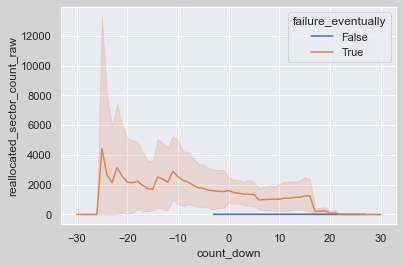

In [219]:
sns.set(rc={'figure.facecolor': "lightgray"})
#ax = sns.lineplot(data=df_hd_model.query("failure_eventually == True"), x="count_down", y="reallocated_sector_count_raw")
#ax = sns.lineplot(data=df_hd_model.query("failure_eventually == False"), x="count_down", y="reallocated_sector_count_raw")
ax = sns.lineplot(data=df_hd_model, x="count_down", y="reallocated_sector_count_raw", hue="failure_eventually")

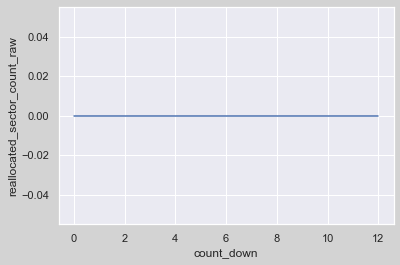

In [220]:
serial = serial_failure[10]
ax = sns.lineplot(data=df_hd_model.query("serial_number == @serial"), x="count_down", y="reallocated_sector_count_raw")

In [221]:
df_hd_model.query("serial_number == @serial")

,date,serial_number,model,failure,spin_up_time_raw,reallocated_sector_count_raw,seek_error_rate_raw,power_on_time_raw,reported_uncorrectable_error_raw,command_timeout_count_raw,current_pending_sector_count_raw,uncorrectable_sector_count_raw,capacity_gb,count_down,day_of_failure,failure_eventually
15465,2021-01-01,S300Z4NB,ST4000DM000,0,0.0,0.0,940532106.0,46975.0,0.0,0.0,0.0,0.0,3726.023277,12,2021-01-13,True
34370,2021-01-02,S300Z4NB,ST4000DM000,0,0.0,0.0,941494961.0,46999.0,0.0,0.0,0.0,0.0,3726.023277,11,2021-01-13,True
53301,2021-01-03,S300Z4NB,ST4000DM000,0,0.0,0.0,943321229.0,47023.0,0.0,0.0,0.0,0.0,3726.023277,10,2021-01-13,True
72237,2021-01-04,S300Z4NB,ST4000DM000,0,0.0,0.0,944541192.0,47047.0,0.0,0.0,0.0,0.0,3726.023277,9,2021-01-13,True
91171,2021-01-05,S300Z4NB,ST4000DM000,0,0.0,0.0,946990591.0,47071.0,0.0,0.0,0.0,0.0,3726.023277,8,2021-01-13,True
110105,2021-01-06,S300Z4NB,ST4000DM000,0,0.0,0.0,948325773.0,47095.0,0.0,0.0,0.0,0.0,3726.023277,7,2021-01-13,True
129043,2021-01-07,S300Z4NB,ST4000DM000,0,0.0,0.0,950255713.0,47119.0,0.0,0.0,0.0,0.0,3726.023277,6,2021-01-13,True
147978,2021-01-08,S300Z4NB,ST4000DM000,0,0.0,0.0,951649854.0,47143.0,0.0,0.0,0.0,0.0,3726.023277,5,2021-01-13,True
166912,2021-01-09,S300Z4NB,ST4000DM000,0,0.0,0.0,953101108.0,47166.0,0.0,0.0,0.0,0.0,3726.023277,4,2021-01-13,True
185846,2021-01-10,S300Z4NB,ST4000DM000,0,0.0,0.0,954831174.0,47190.0,0.0,0.0,0.0,0.0,3726.023277,3,2021-01-13,True


<AxesSubplot:xlabel='count_down', ylabel='reallocated_sector_count_raw'>

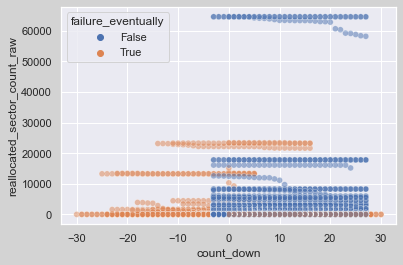

In [225]:
sns.scatterplot(data=df_hd_model, x="count_down", y="reallocated_sector_count_raw", hue="failure_eventually", alpha=0.5)

In [226]:
df_hd_model.describe().T

,count,mean,std,min,25%,50%,75%,max
failure,1701863.0,3.466789e-05,5.887844e-03,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
spin_up_time_raw,1701863.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
reallocated_sector_count_raw,1701863.0,1.187305e+01,5.371798e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.463200e+04
seek_error_rate_raw,1701863.0,1.553001e+10,2.046827e+12,12.000000,4.031908e+08,5.982994e+08,7.823218e+08,2.814711e+14
power_on_time_raw,1701863.0,4.659424e+04,3.143310e+03,0.000000,4.458200e+04,4.634400e+04,4.862700e+04,5.756500e+04
reported_uncorrectable_error_raw,1701863.0,7.000681e-01,6.987016e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.040000e+02
command_timeout_count_raw,1701863.0,3.175873e-02,1.050281e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.200000e+01
current_pending_sector_count_raw,1701863.0,2.881191e+00,2.853225e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.104000e+04
uncorrectable_sector_count_raw,1701863.0,2.881191e+00,2.853225e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.104000e+04
capacity_gb,1701863.0,3.726023e+03,0.000000e+00,3726.023277,3.726023e+03,3.726023e+03,3.726023e+03,3.726023e+03


In [227]:
df_hd_model.query("failure_eventually == False").describe().T

,count,mean,std,min,25%,50%,75%,max
failure,1699204.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
spin_up_time_raw,1699204.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
reallocated_sector_count_raw,1699204.0,9.911125e+00,5.072809e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.463200e+04
seek_error_rate_raw,1699204.0,1.554981e+10,2.048428e+12,12.000000,4.031857e+08,5.982055e+08,7.821939e+08,2.814711e+14
power_on_time_raw,1699204.0,4.659473e+04,3.144712e+03,0.000000,4.458200e+04,4.634300e+04,4.862900e+04,5.756500e+04
reported_uncorrectable_error_raw,1699204.0,6.725979e-01,6.858468e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.040000e+02
command_timeout_count_raw,1699204.0,3.153359e-02,1.050006e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.200000e+01
current_pending_sector_count_raw,1699204.0,2.846029e+00,2.855303e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.104000e+04
uncorrectable_sector_count_raw,1699204.0,2.846029e+00,2.855303e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.104000e+04
capacity_gb,1699204.0,3.726023e+03,0.000000e+00,3726.023277,3.726023e+03,3.726023e+03,3.726023e+03,3.726023e+03


In [ ]:
# randomly get some healthy hds for balancing the data
RSEED = 40
size_multiple_factor = 3
final_date = pd.Period(end_date) - 30
df_hd_model_healthy = df_hd_model.query("failure == 0 and date == @final_date")
df_hd_model_healthy = df_hd_model_healthy[~df_hd_model_healthy["serial_number"].isin(serial_failure)].sample(size_multiple_factor*len(df_hd_model_failure), random_state=RSEED)
df_hd_model_healthy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189 entries, 1718560 to 1722693
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   date                              189 non-null    object 
 1   serial_number                     189 non-null    object 
 2   model                             189 non-null    object 
 3   failure                           189 non-null    int64  
 4   spin_up_time_raw                  189 non-null    float64
 5   reallocated_sector_count_raw      189 non-null    float64
 6   seek_error_rate_raw               189 non-null    float64
 7   reported_uncorrectable_error_raw  189 non-null    float64
 8   command_timeout_count_raw         189 non-null    float64
 9   current_pending_sector_count_raw  189 non-null    float64
 10  uncorrectable_sector_count_raw    189 non-null    float64
 11  capacity_gb                       189 non-null    float64
dty

In [58]:
df_hd_model_cut = pd.concat([df_hd_model_failure, df_hd_model_healthy], ignore_index=True)
df_hd_model_cut.head()

,date,serial_number,model,failure,spin_up_time_raw,reallocated_sector_count_raw,seek_error_rate_raw,reported_uncorrectable_error_raw,command_timeout_count_raw,current_pending_sector_count_raw,uncorrectable_sector_count_raw,capacity_gb
0,2021-01-01,ZJV4MDYR,ST12000NM0007,1,0.0,33104.0,7.057052e+08,87.0,0.000000e+00,0.0,0.0,11176.0
1,2021-01-04,ZCH07WP7,ST12000NM0007,1,0.0,9173.0,4.298070e+09,870.0,0.000000e+00,0.0,0.0,11176.0
2,2021-01-04,ZCH0DG4W,ST12000NM0007,1,0.0,35080.0,6.666953e+08,300.0,0.000000e+00,0.0,0.0,11176.0
3,2021-01-05,ZJV4LWRR,ST12000NM0007,1,0.0,304.0,8.534049e+08,13.0,0.000000e+00,0.0,0.0,11176.0
4,2021-01-06,ZCH07HR7,ST12000NM0007,1,0.0,12800.0,4.677768e+08,53.0,4.295098e+09,584.0,584.0,11176.0


In [ ]:
# setup for reading time series
#serials = ['ZLW0EGC6', 'Z305B2QN', 'ZLW0C6NE', 'ZJV0XJQ3', 'ZLW18MKT', 'ZLW0GGTP']
serials = ['ZLW0EGC6', 'ZLW0GGTP']
start_date = "2021-01-11"
end_date = "2021-01-12"
days = pd.Period(end_date).dayofyear - pd.Period(start_date).dayofyear + 1
column_to_save = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure', 'smart_1_normalized']
#column_to_save = ['date', 'capacity_bytes', 'failure', 'smart_1_normalized']
#column_to_save = column_name_all

# Prepare the DataFrame for Time Series

In [ ]:
# create a list of empty dataframes for concatenation later
time_series_dataset = []
for serial in serials:
    time_series_dataset.append(pd.DataFrame([], columns=column_to_save))

memory_used = 0
memory_warning_displayed = False
print(f"Read files for building time series from {start_date} to {end_date}; totally {days} days; {len(serials)} serials")
for day in range(days):
    date = pd.Period(start_date) + day
    print(f"  reading data for the date {date}; progress: {day+1}/{days}")
    file_path = repository_directory + "data/data_Q1_2021/" + str(date) + ".csv"
    df_tmp = pd.read_csv(file_path, parse_dates=["date"])
    for i, serial in enumerate(serials):
        df_tmp_serial = df_tmp.query("serial_number == @serial")[column_to_save]
        time_series_dataset[i] = pd.concat([time_series_dataset[i], df_tmp_serial], ignore_index=True)
        memory_used += time_series_dataset[i].memory_usage(deep=True).sum()
    if memory_used/1024**3 > 1 and not memory_warning_displayed:
        print(" ### Warning: memory used for time-series dataframe > 1 GB ###")
        memory_warning_displayed = True

print("Time series was read successfully")
print(f"Memory used for dataframe: {(memory_used/1024**3).round(3)} GB")

Read files for building time series from 2021-01-11 to 2021-01-12; totally 2 days; 2 serials
  reading data for the date 2021-01-11; progress: 1/2
  reading data for the date 2021-01-12; progress: 2/2
Time series was read successfully
Memory used for dataframe: 0.0 GB


In [ ]:
# check the dataframe of a HDD specified by choice
choice = 1
time_series_dataset[choice].head(5)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized
0,2021-01-11,ZLW0GGTP,ST12000NM001G,12000138625024,0,83.0
1,2021-01-12,ZLW0GGTP,ST12000NM001G,12000138625024,0,83.0


In [ ]:
time_series_dataset[choice].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                2 non-null      datetime64[ns]
 1   serial_number       2 non-null      object        
 2   model               2 non-null      object        
 3   capacity_bytes      2 non-null      object        
 4   failure             2 non-null      object        
 5   smart_1_normalized  2 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 224.0+ bytes


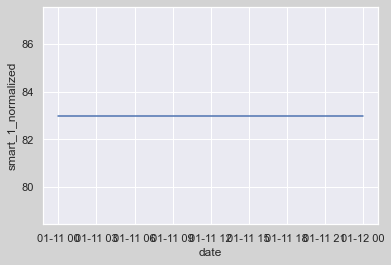

In [ ]:
sns.set(rc={'figure.facecolor': "lightgray"})
ax = sns.lineplot(data=time_series_dataset[choice], x="date", y="smart_1_normalized")

In [ ]:
print("Save read time series to csv files")
for i, serial in enumerate(serials):
    file_path = repository_directory + "data/time_series/" + serial + "_" + start_date + "_to_" + end_date + ".csv" 
    time_series_dataset[i].to_csv(file_path)
    print(f"  save to \"{file_path}\"; progress {i}/{len(serials)}")
print("Time series are saved successfully")

Save read time series to csv files
  save to "../data/time_series/ZLW0EGC6_2021-01-11_to_2021-01-12.csv"; progress 0/2
  save to "../data/time_series/ZLW0GGTP_2021-01-11_to_2021-01-12.csv"; progress 1/2
Time series are saved successfully


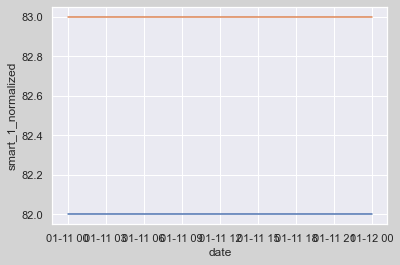

In [ ]:
sns.set(rc={'figure.facecolor': "lightgray"})
for i, serial in enumerate(serials):
    ax = sns.lineplot(data=time_series_dataset[i], x="date", y="smart_1_normalized")

# EDA

In [ ]:
# randomly get some healthy hds for balancing the data
RSEED = 40
df_hd_model_healthy = df_source[~df_source["serial_number"].isin(serial_failure)].query("model == @hd_model").sample(len(df_hd_model_failure), random_state=RSEED)[column_to_save]
df_hd_model_healthy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 146000 to 98945
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            66 non-null     datetime64[ns]
 1   serial_number   66 non-null     object        
 2   model           66 non-null     object        
 3   capacity_bytes  66 non-null     int64         
 4   failure         66 non-null     int64         
 5   smart_3_raw     66 non-null     float64       
 6   smart_5_raw     66 non-null     float64       
 7   smart_7_raw     66 non-null     float64       
 8   smart_9_raw     66 non-null     float64       
 9   smart_187_raw   66 non-null     float64       
 10  smart_188_raw   66 non-null     float64       
 11  smart_190_raw   66 non-null     float64       
 12  smart_197_raw   66 non-null     float64       
 13  smart_198_raw   66 non-null     float64       
dtypes: datetime64[ns](1), float64(9), int64(2), object(2

In [ ]:
# concat the healthy and failed hd data

df_hd_model = pd.concat([df_hd_model_healthy, df_hd_model_failure], ignore_index=True)
#df_hd_model.nunique()

## Data cleaning


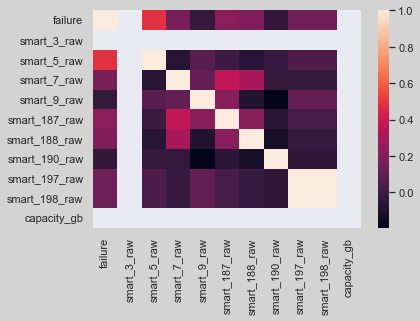

In [ ]:
correlation = df_hd_model.corr()
ax = sns.heatmap(correlation)

In [ ]:
correlation

,failure,smart_3_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_190_raw,smart_197_raw,smart_198_raw,capacity_gb
failure,1.000000,NaN,0.484475,0.166536,-0.027968,0.221913,0.191448,-0.031826,0.141386,0.141386,NaN
smart_3_raw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_5_raw,0.484475,NaN,1.000000,-0.068325,0.082732,0.000812,-0.065799,-0.027921,0.051119,0.051119,NaN
smart_7_raw,0.166536,NaN,-0.068325,1.000000,0.115838,0.373303,0.304595,-0.027160,-0.024322,-0.024322,NaN
smart_9_raw,-0.027968,NaN,0.082732,0.115838,1.000000,0.215172,-0.089453,-0.194701,0.109857,0.109857,NaN
smart_187_raw,0.221913,NaN,0.000812,0.373303,0.215172,1.000000,0.213459,-0.058494,0.029185,0.029185,NaN
smart_188_raw,0.191448,NaN,-0.065799,0.304595,-0.089453,0.213459,1.000000,-0.118084,-0.022946,-0.022946,NaN
smart_190_raw,-0.031826,NaN,-0.027921,-0.027160,-0.194701,-0.058494,-0.118084,1.000000,-0.045308,-0.045308,NaN
smart_197_raw,0.141386,NaN,0.051119,-0.024322,0.109857,0.029185,-0.022946,-0.045308,1.000000,1.000000,NaN
smart_198_raw,0.141386,NaN,0.051119,-0.024322,0.109857,0.029185,-0.022946,-0.045308,1.000000,1.000000,NaN


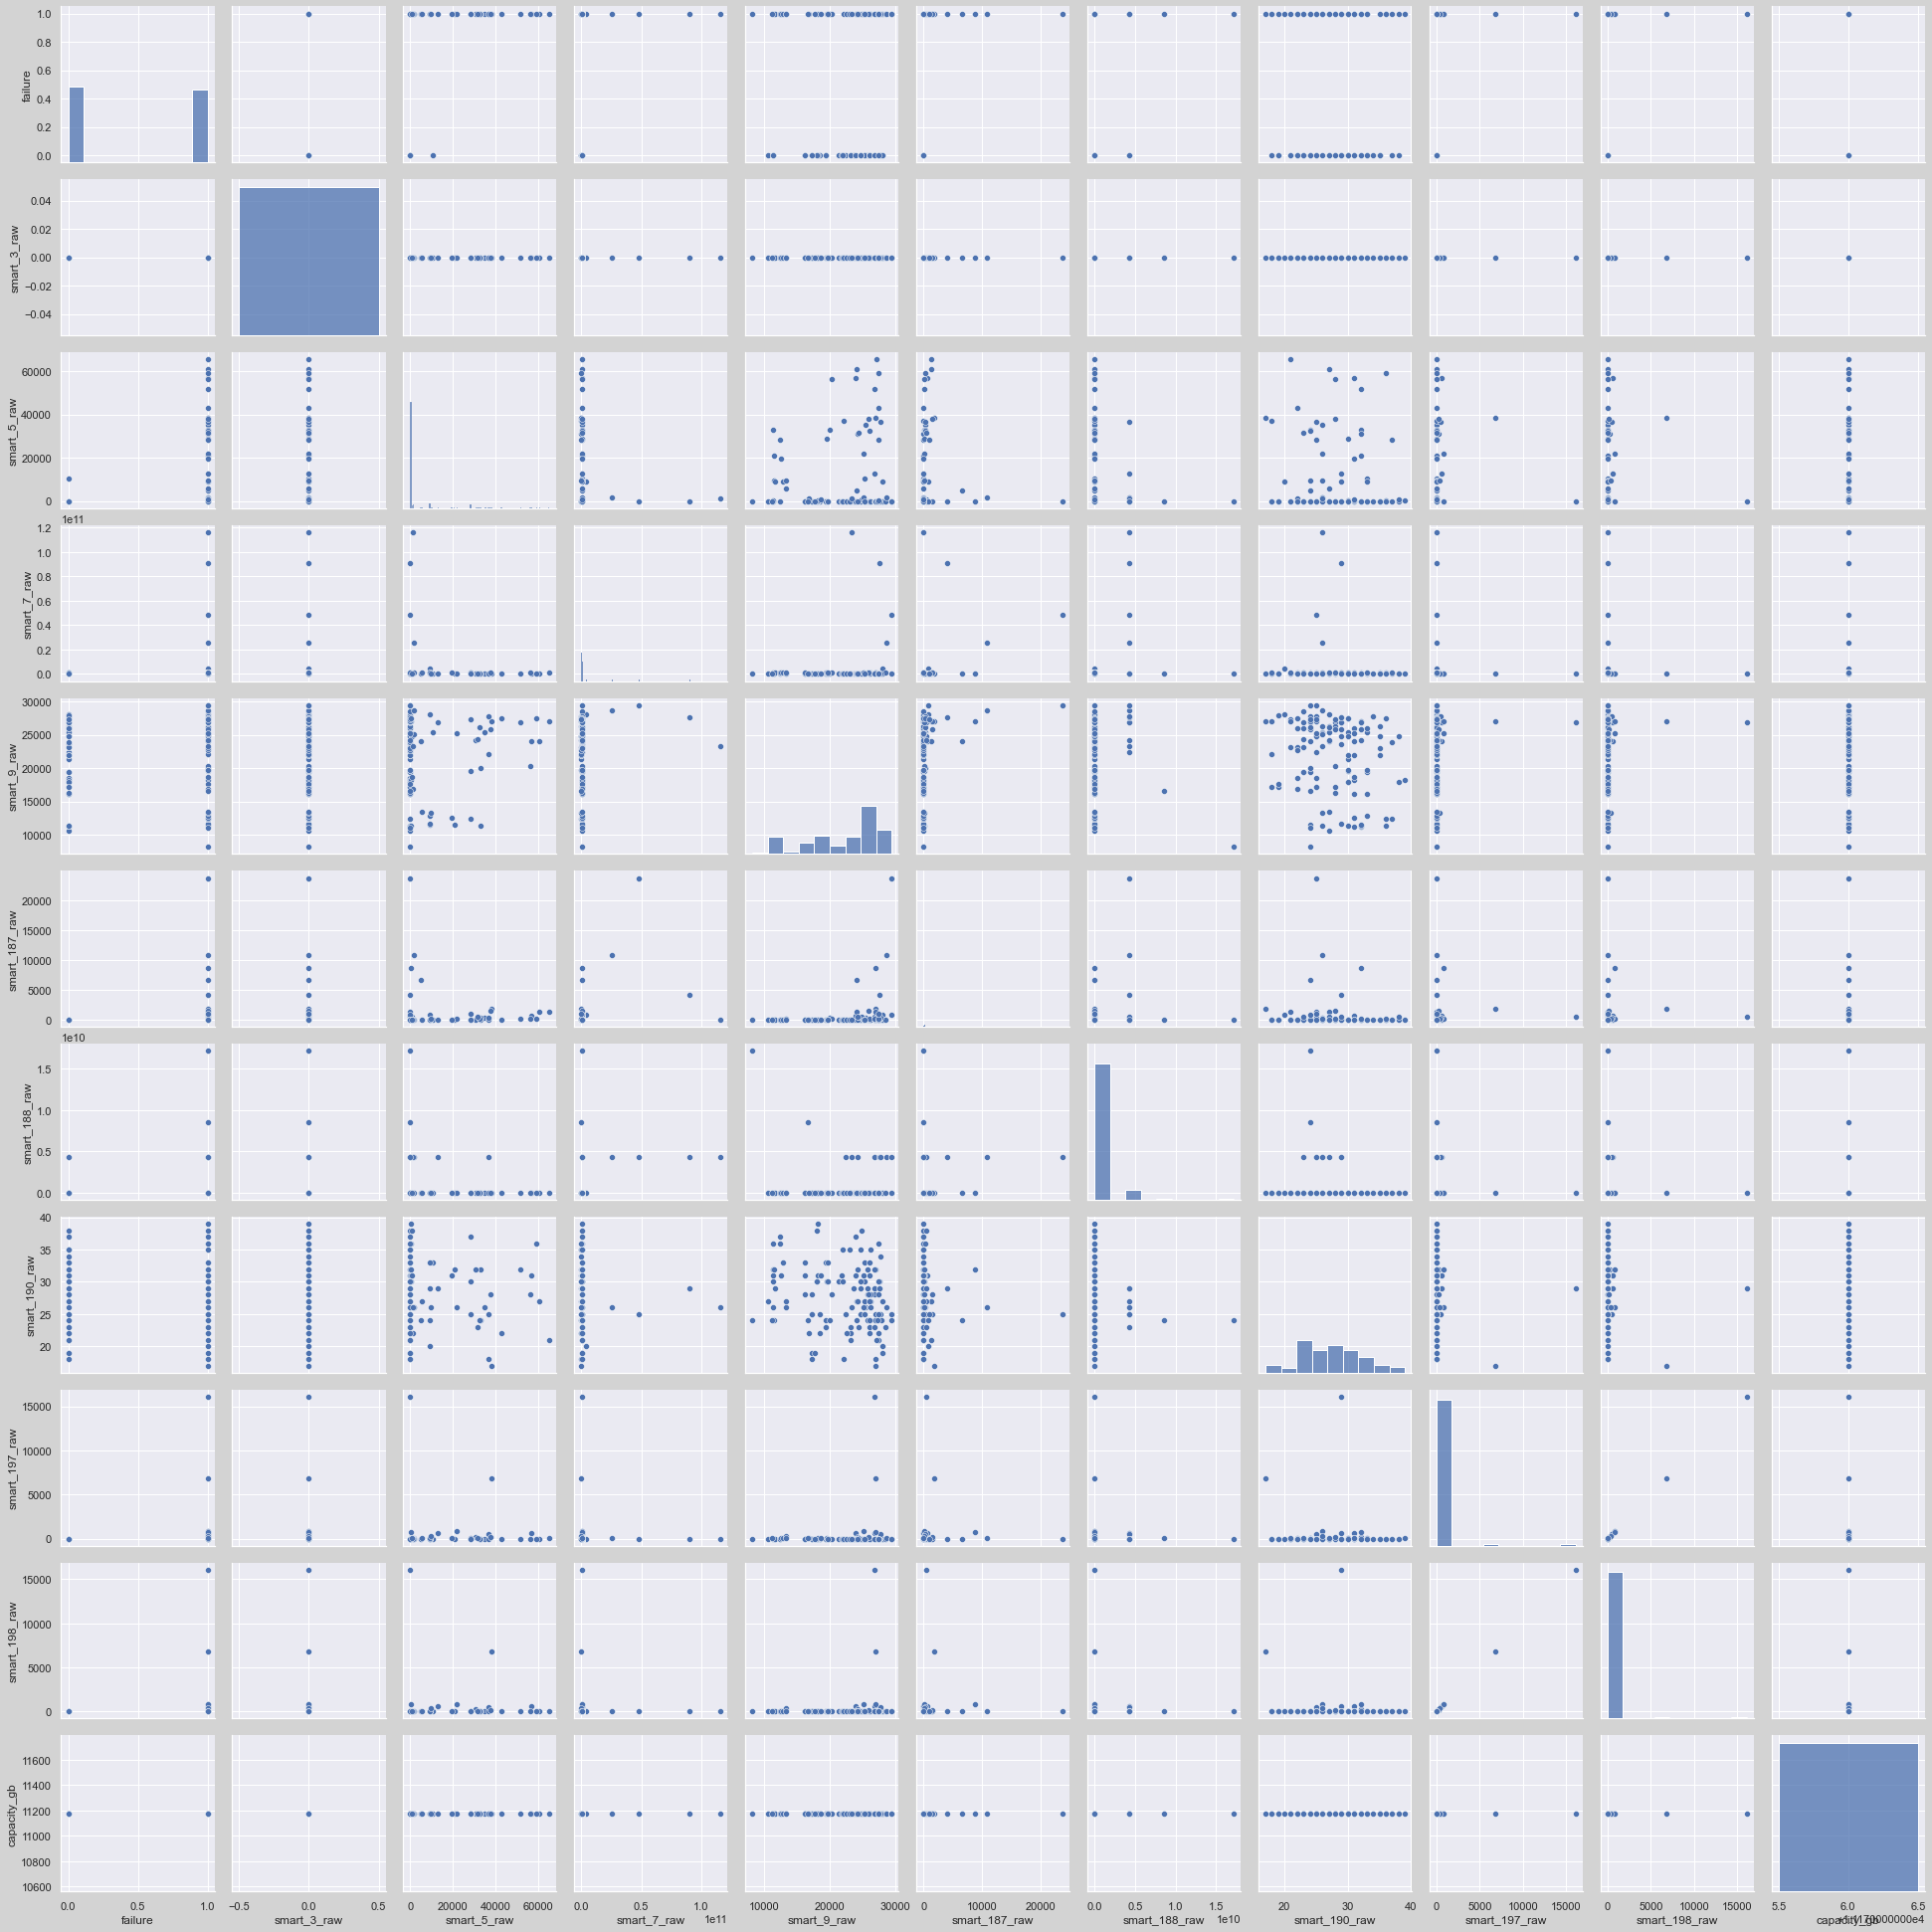

In [ ]:
ax = sns.pairplot(data=df_hd_model)

In [ ]:
from sklearn.feature_selection import mutual_info_classif

entropy = mutual_info_classif(df_hd_model[["smart_5_raw", "smart_7_raw", "smart_9_raw", "smart_187_raw", "smart_188_raw", "smart_190_raw", "smart_197_raw", "smart_198_raw", "capacity_gb"]], df_hd_model["failure"], random_state=100)

In [ ]:
entropy

array([0.31521963, 0.02978993, 0.18079568, 0.29907047, 0.02965421,
       0.02191428, 0.16545779, 0.17785167, 0.02469974])

In [ ]:
df_hd_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 131
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           129 non-null    datetime64[ns]
 1   serial_number  129 non-null    object        
 2   failure        129 non-null    int64         
 3   smart_3_raw    129 non-null    float64       
 4   smart_5_raw    129 non-null    float64       
 5   smart_7_raw    129 non-null    float64       
 6   smart_9_raw    129 non-null    float64       
 7   smart_187_raw  129 non-null    float64       
 8   smart_188_raw  129 non-null    float64       
 9   smart_190_raw  129 non-null    float64       
 10  smart_197_raw  129 non-null    float64       
 11  smart_198_raw  129 non-null    float64       
 12  capacity_gb    129 non-null    float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(1)
memory usage: 18.2+ KB
